In [1]:

from src._clusterstability import *

/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
categories = ['sci.space']#, 'talk.religion.misc', 'comp.graphics', 'alt.atheism']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
topics = get_eigen_topics(newsgroups_train.data)

CountVectorizer(stop_words='english')


/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
topics

['ironic lbj mippselled dubbed umm surreal moments yeager',
 'nasa space lunar available mars probe moon information',
 'probe surface mars lunar moon probes orbit mariner',
 'larson theory universe physical unified star motion physicist',
 'data nasa available ftp images launch directory gov',
 'space propulsion news edu box technical lunar year',
 'propulsion fusion lunar design power isbn rocket energy',
 'astronaut nasa pilot shuttle candidates military mission degree',
 'edu sci faq com shuttle propulsion list posts',
 '14 000 1993 faq 93 titan van earth']

In [6]:
from datasets import load_dataset
ds = load_dataset("Gustavosta/Stable-Diffusion-Prompts")
    

Using custom data configuration Gustavosta--Stable-Diffusion-Prompts-d22aeec0ba2a9fdb
Found cached dataset parquet (/home/codespace/.cache/huggingface/datasets/Gustavosta___parquet/Gustavosta--Stable-Diffusion-Prompts-d22aeec0ba2a9fdb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 569.96it/s]


In [7]:
prompts = []
for i, prompt in enumerate(ds['train']):
    prompts.append(prompt['Prompt'])

In [8]:
from sentence_transformers import SentenceTransformer, util
import torch

In [9]:
len(prompts)

73718

In [10]:

model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device='cpu')
embeddings = model.encode(prompts)

In [26]:
embeddings.shape

(73718, 384)

In [12]:
queries = []
top_k = 1
for topic in topics:
    tq = model.encode([topic], device='cpu')
    cos_scores = util.cos_sim(tq, embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    print("\n\nTopic: ", topic)
    print("Top 2 most similar prompts:")
    for score, idx in zip(top_results[0], top_results[1]):
        print(prompts[idx], "(Score: %.4f)" % (score))
        if score > 0.5:
            queries.append(prompts[idx])
        print('\n')
    



Topic:  ironic lbj mippselled dubbed umm surreal moments yeager
Top 2 most similar prompts:
vintage 90's anime mixed with pastel impasto highly rhythmic expressionistic wild symmetrical  cutest adorable portrait of HATSUNE MIKU pleasing palette trending on artstation funhouse surreal unpredictable wild unexplainable fantasy land you could not have dreamed of in the gritty posterized grainy analog style of studio Ghibli and 1960s americana Comics, HQ 8k scan (Score: 0.4992)




Topic:  nasa space lunar available mars probe moon information
Top 2 most similar prompts:
astronauts fighting aliens on the moon, trending on artstation, horror, science fiction (Score: 0.6034)




Topic:  probe surface mars lunar moon probes orbit mariner
Top 2 most similar prompts:
astronauts fighting aliens on the moon, trending on artstation, horror, science fiction (Score: 0.5519)




Topic:  larson theory universe physical unified star motion physicist
Top 2 most similar prompts:
sci-fi concept art in sp

In [15]:
from PIL import Image
import requests as r
from io import BytesIO  
def query_lexica(query, num_images=5):
    '''
    query: string
    num_images: int
    '''
    resp = r.get(f"https://lexica.art/api/v1/search?q={query}", timeout=5)
    images = []
    for img in resp.json()['images']:
        if len(images) == num_images:
            break
        url = img['src']
        response = r.get(url, timeout=5)
        img = Image.open(BytesIO(response.content))
        images.append(img)
    return images

In [18]:
images = []
for query in queries:
    image = query_lexica(query, num_images=2)
    images+= image

In [19]:
len(images)

14

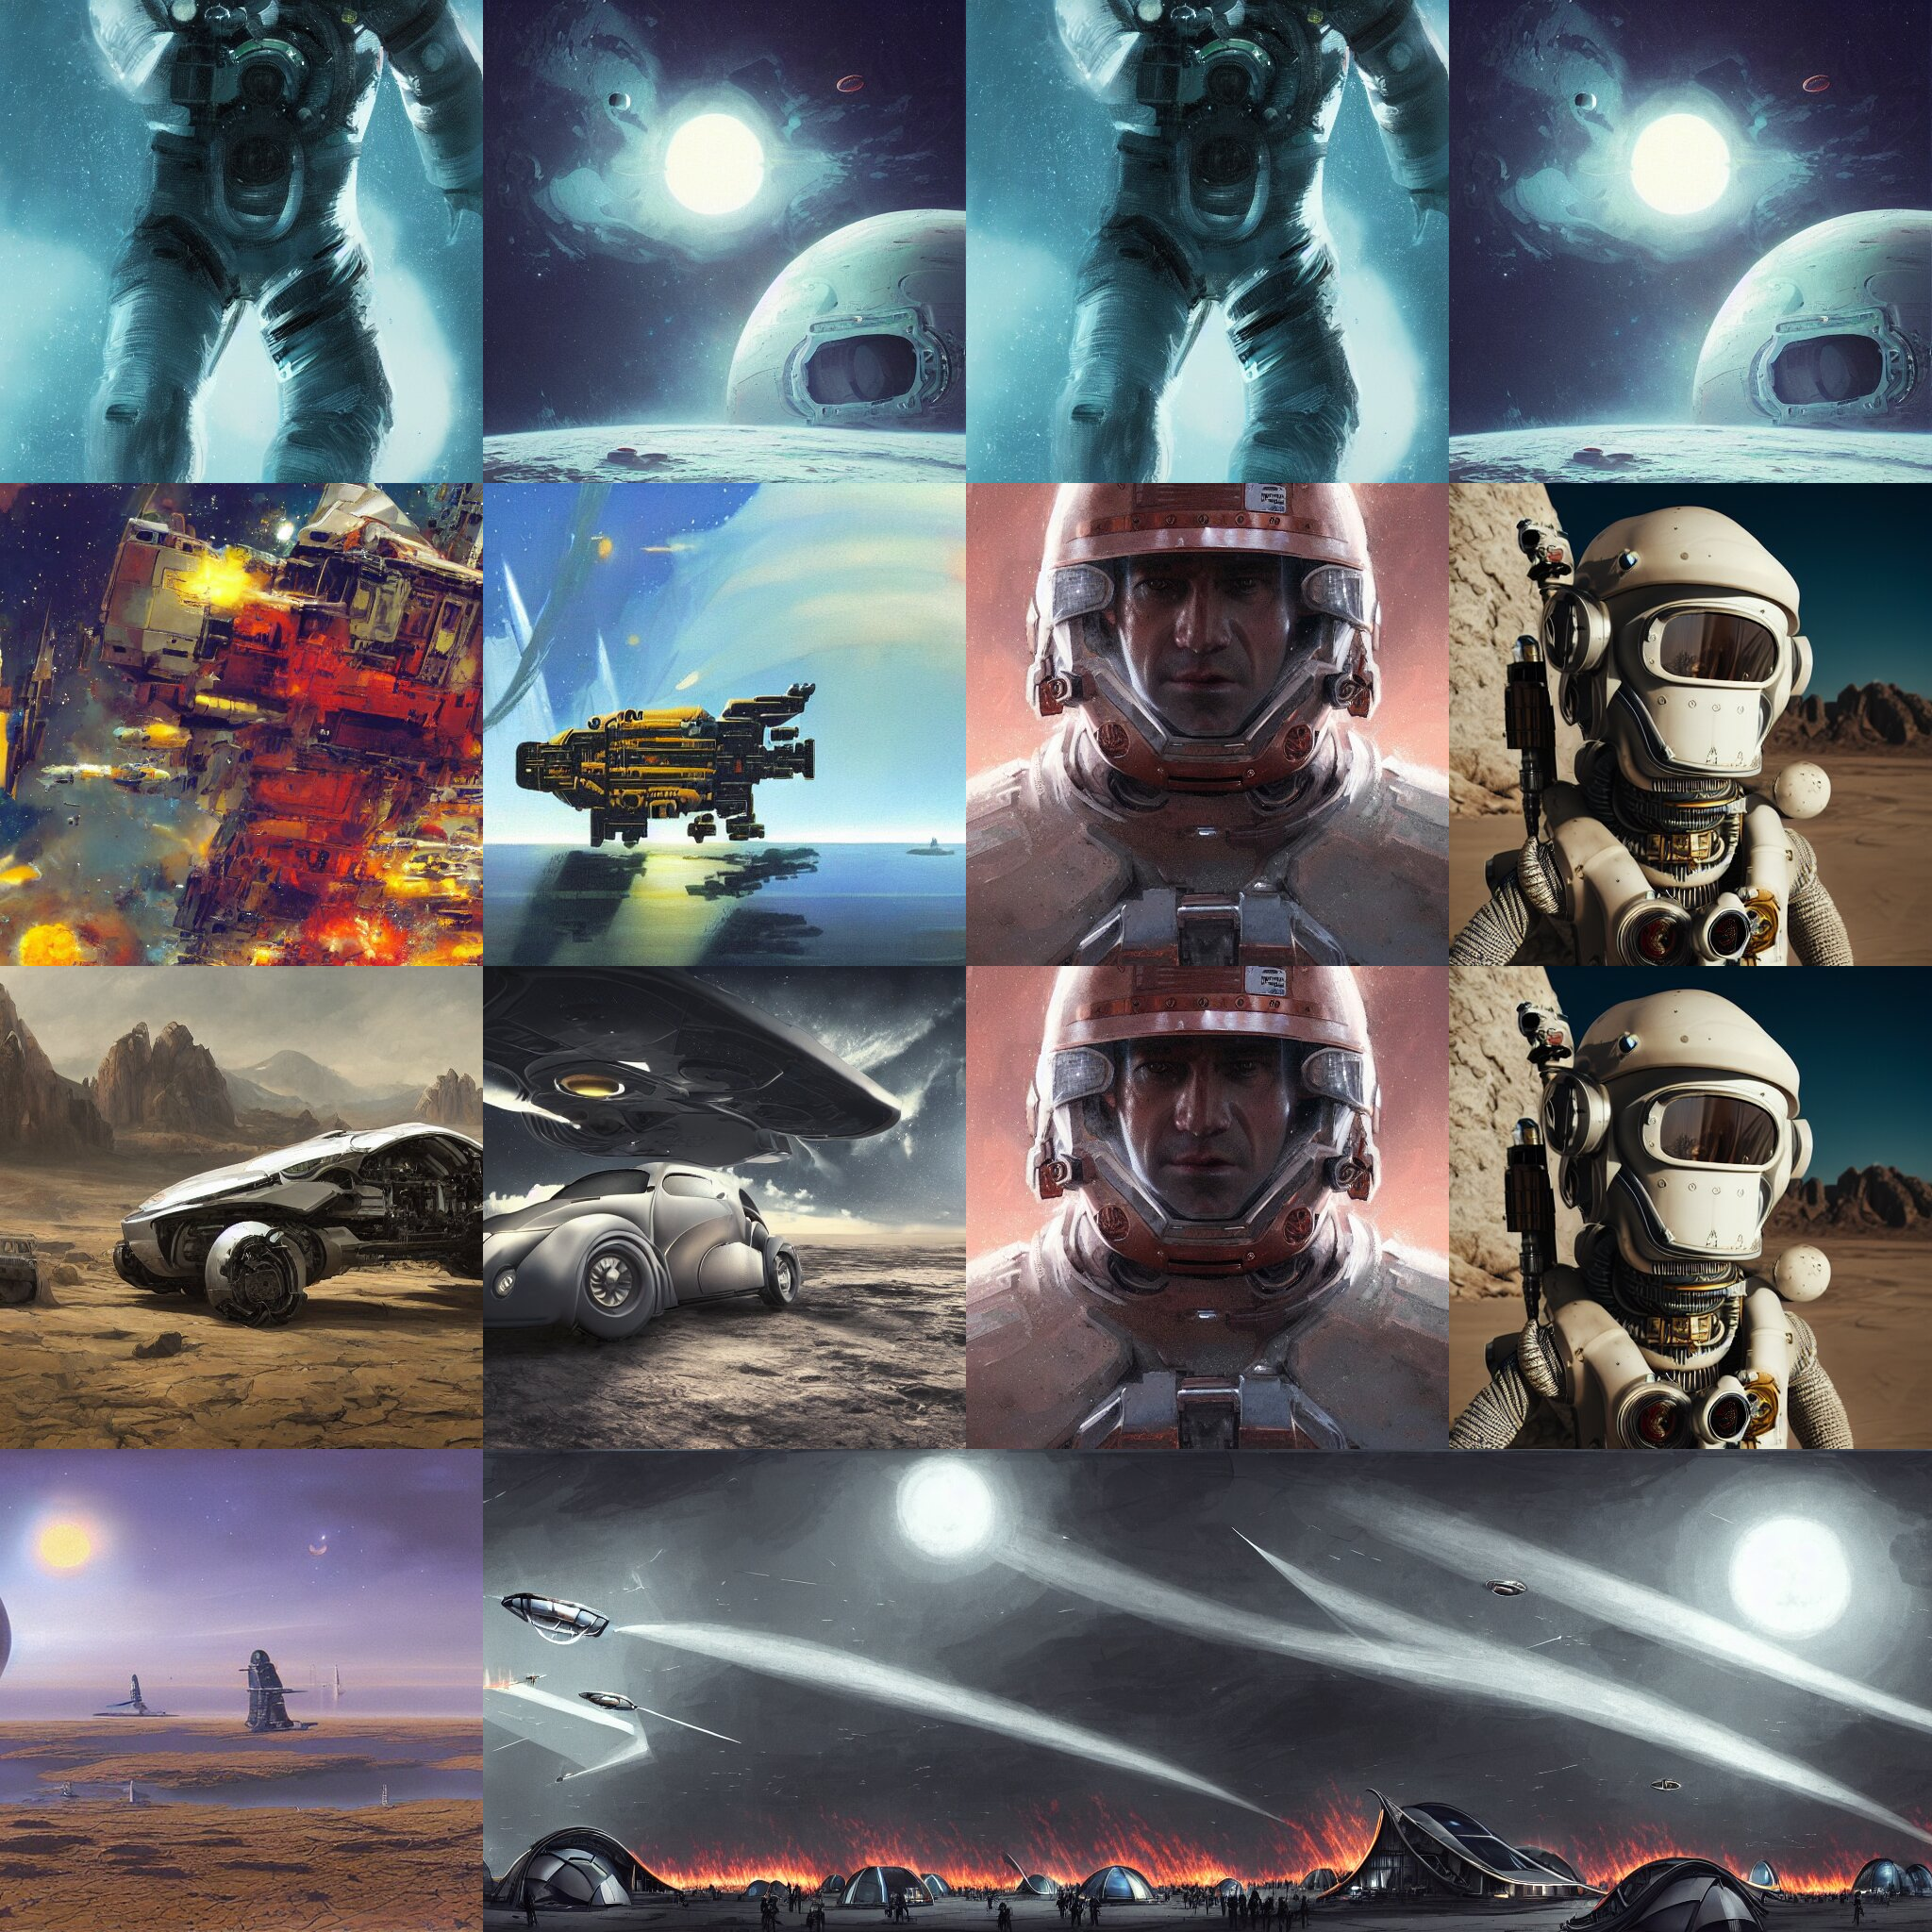

In [21]:
display(image_grid(images, 4,4 ))